In [1]:
from keras.models import load_model
import os


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Directories
# base_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir+ os.sep + os.pardir)

# h5_dir = os.path.join(base_dir,'h5')
# dataset = os.path.join(base_dir,'dataset')
dataset_images =  os.path.join('dataset','Images')
# img_path =  os.path.join(dataset_images,'image_act_01.png')
# print(img_path)
img_path = dataset_images+os.sep+'image_act_01.png'
print(img_path)

dataset/Images/image_act_01.png


In [3]:
#Paramters
image_height , image_width = 128,128

In [4]:
model = load_model('h5'+os.sep+'cnn_model_aB9_v3.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)       147584    
__________

In [5]:
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(image_height, image_width))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor,axis=0)
img_tensor/=255.

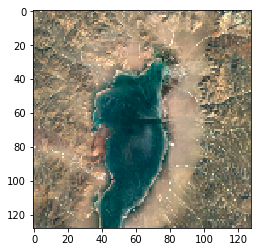

In [7]:
#Display the image
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [8]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [13]:
#Running the model in predict mode
activations =activation_model.predict(img_tensor)

print(activations[0].shape)

(1, 126, 126, 32)


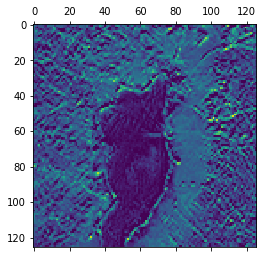

In [28]:
#Dispay Fourth Channel of 1st conv2D
plt.matshow(activations[0][0,:,:,4],cmap='viridis' )

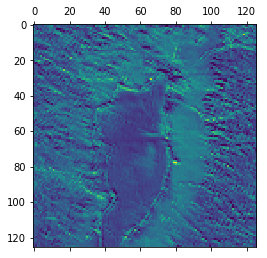

In [29]:
#Dispay Seventh Channel of 1st conv2D
plt.matshow(activations[0][0,:,:,7],cmap='viridis' )

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in divide


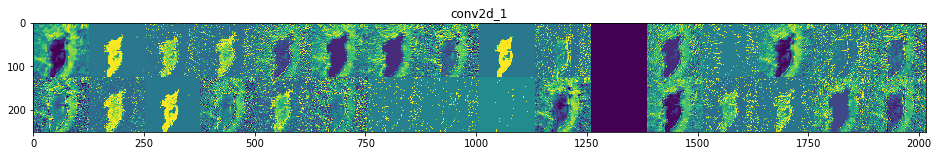

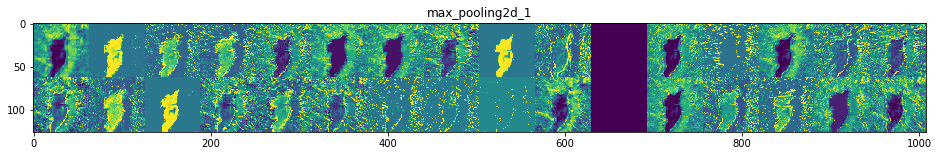

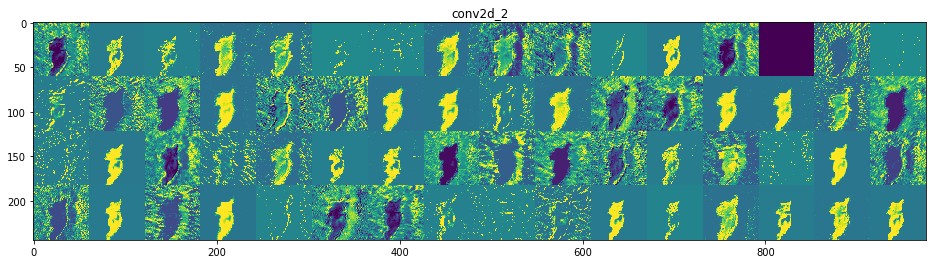

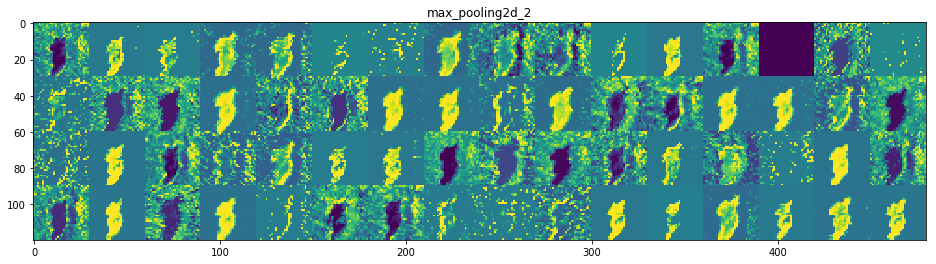

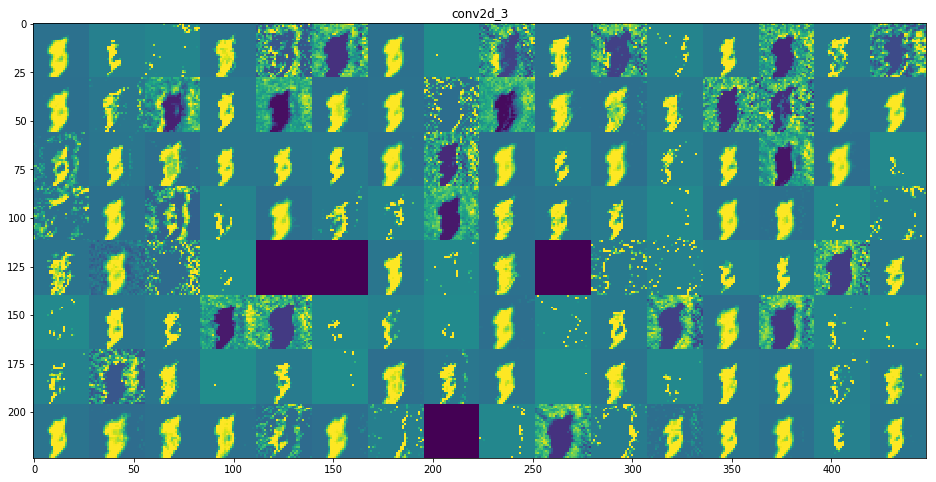

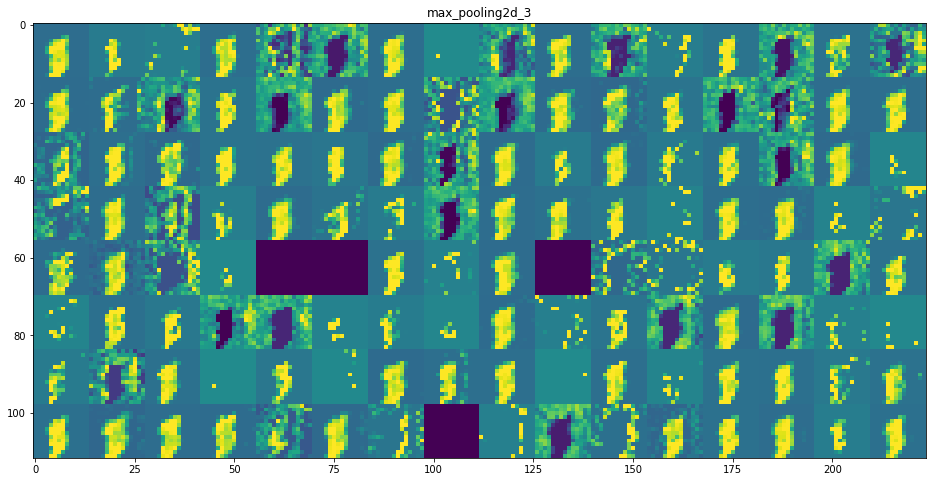

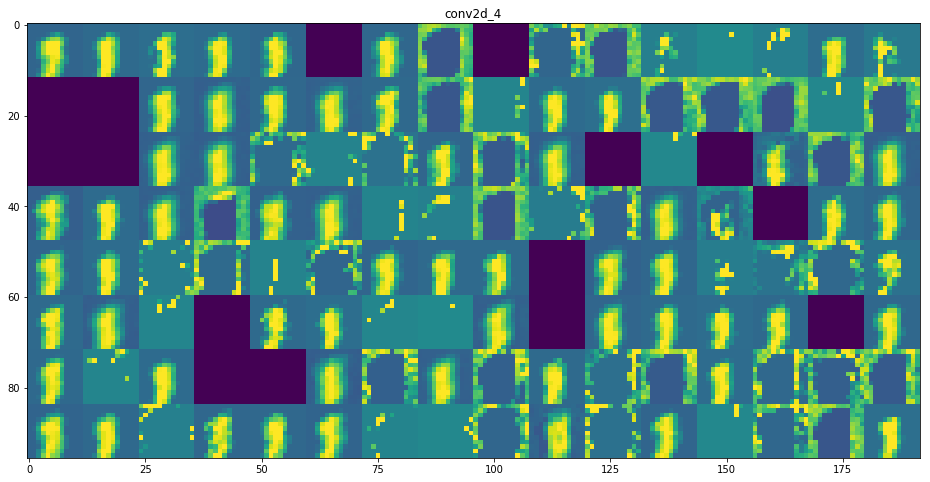

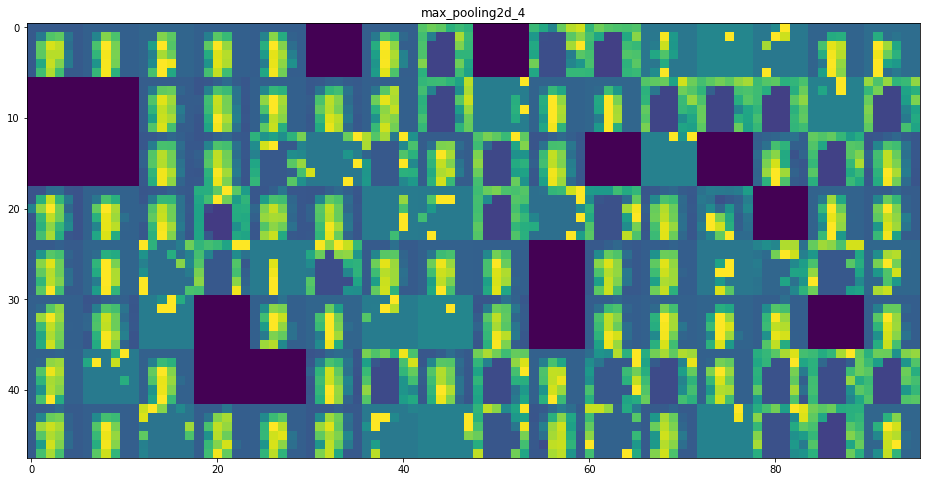

In [30]:
#VIsualizing every channel in every intermediate layers
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16


for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [31]:
#Defining the loss tensor for filter visualization

from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

58900480/58889256 [==============================] - 30s 1us/step


In [32]:
#Obtaining the gradient of the loss with regard to the input
grads = K.gradients(loss, model.input)[0]

In [33]:
#Gradient normalization trick
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [34]:
# Fetching Numpy output values given Numpy input values
iterate = K.function([model.input], [loss, grads])

import numpy as np

loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [35]:
# Loss maximization via stochastic gradient descent
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
step = 1.

for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [36]:
# Utility function to convert a tensor into a valid image

def deprocess_image(x):
    #Normalizes the tensor: centers on 0, ensure that std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    #Clips to [0,1]
    x += 0.5
    x = np.clip(x, 0, 1)
    
    #Converts to an RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [37]:
#Function to generate filter visaulization
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

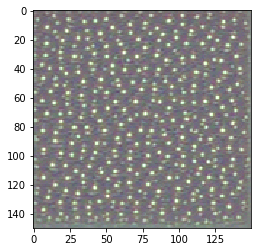

In [50]:
plt.imshow(generate_pattern('block3_conv1', 0))

# Generating Grid of all filter response patterns in a layer

In [ ]:
layer_name = 'block1_conv1'
size = 64
margin = 5
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))
for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,
                vertical_start: vertical_end, :] = filter_img

plt.figure(figsize=(20, 20))
plt.imshow(results)

In [ ]:
def generate_layer_response_patterns(layer_name):
    size = 64
    margin = 5
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))
    for i in range(8):
        for j in range(8):
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end,
                    vertical_start: vertical_end, :] = filter_img

    plt.figure(figsize=(20, 20))
    plt.imshow(results)

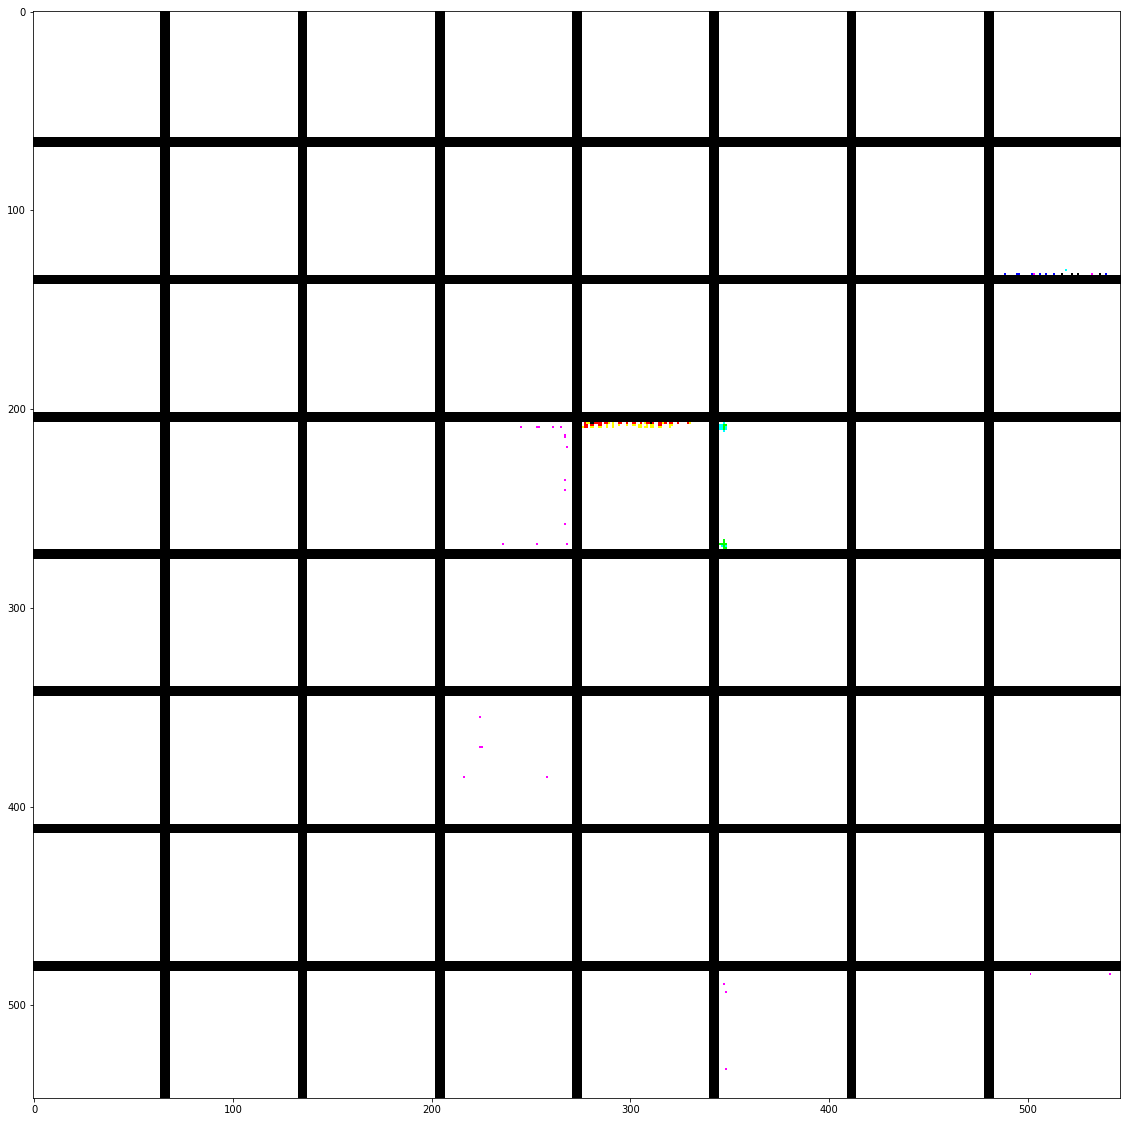

In [52]:
layer_name = 'block2_conv1'
size = 64
margin = 5


results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
plt.figure(figsize=(20, 20))
plt.imshow(results)

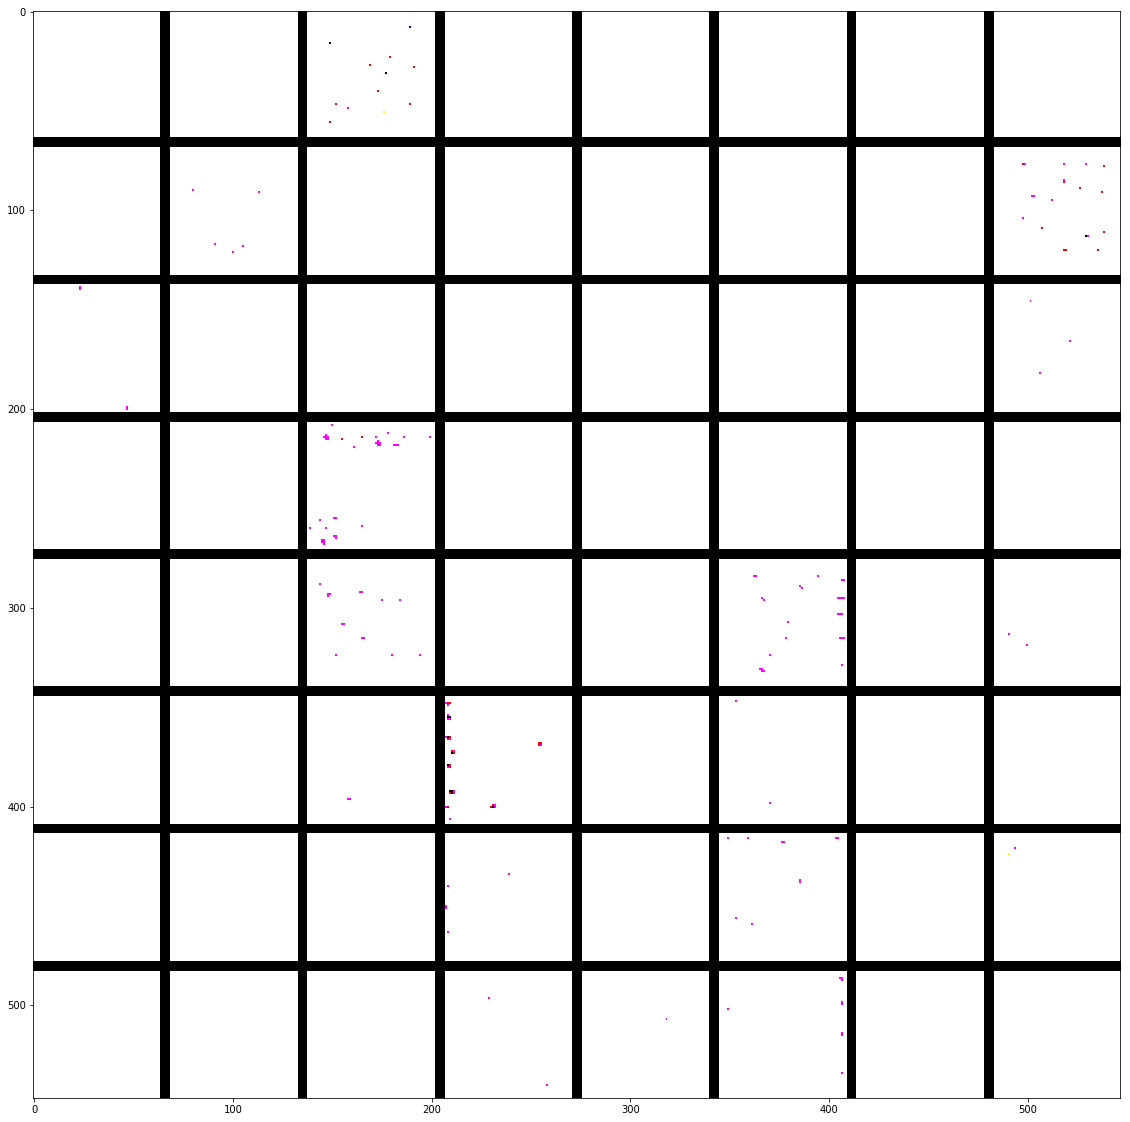

In [53]:
layer_name = 'block3_conv1'
size = 64
margin = 5


results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
plt.figure(figsize=(20, 20))
plt.imshow(results)

In [ ]:
layer_name = 'block4_conv1'
size = 64
margin = 5


results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
plt.figure(figsize=(20, 20))
plt.imshow(results)